In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import datetime as dt

from swarmpal.io import PalDataItem, create_paldata
from swarmpal_mma.pal_processes import MMA_SHA_2E

/users/ngp/SwarmPAL/mma-for-swarmpal/.venv/lib/python3.10/site-packages/spacepy/time.py:2448: UserWarning: Leapseconds may be out of date. Use spacepy.toolbox.update(leapsecs=True)
  _read_leaps()


## Set configurations

In [3]:
# Global parameters (should always remain the same)
MODEL = "'Model' = 'CHAOS-Core' + 'CHAOS-Static'"
MODEL_WITH_IONO = "'Model' = 'CHAOS-Core' + 'CHAOS-Static' + 'MIO_SHA_2C'"
VIRES_AUXILIARIES = ["MLT", "QDLat", "Dst", "QDBasis", "DipoleAxisVector"]
AVAILABLE_DATASETS = {"Swarm-A": "SW_OPER_MAGA_LR_1B", "Swarm-B": "SW_OPER_MAGB_LR_1B"}
SAMPLING_STEP = "PT25S"

# Tunable parameters
PARAMS = {"LT_limit": 6, "min_gm_lat": 0, "max_gm_lat": 65}
# TODO: See what should be included here from MMA_2E/utils/Config.py

# Local settings (changes with each run) - these determine what external data is used
START_TIME = dt.datetime(2024, 10, 1)
END_TIME = dt.datetime(2024, 11, 1)
# START_TIME = dt.datetime(2024, 10, 1)
# END_TIME = dt.datetime(2024, 10, 2)
SPACECRAFTS_TO_USE = ["Swarm-A", "Swarm-B"]  # corresponds to AVAILABLE_DATASETS

## Fetch data using SwarmPAL

In [4]:
def get_paldatatime_vires_config(
    collection=None, start_time=None, end_time=None, model=None
):
    """Set of options which are passed through to viresclient
    For options, see https://swarmpal.readthedocs.io/en/latest/api/io.html#swarmpal.io.PalDataItem.from_vires
    """
    return dict(
        collection=collection,
        measurements=["B_NEC"],
        models=[model],
        auxiliaries=VIRES_AUXILIARIES,
        sampling_step=SAMPLING_STEP,
        start_time=start_time,
        end_time=end_time,
        server_url="https://vires.services/ows",
        options=dict(asynchronous=True, show_progress=True),
    )


start_time = START_TIME
end_time = END_TIME
model = MODEL
data_config = {
    spacecraft: get_paldatatime_vires_config(
        collection=AVAILABLE_DATASETS.get(spacecraft),
        start_time=start_time,
        end_time=end_time,
        model=model,
    )
    for spacecraft in SPACECRAFTS_TO_USE
}
data_config

{'Swarm-A': {'collection': 'SW_OPER_MAGA_LR_1B',
  'measurements': ['B_NEC'],
  'models': ["'Model' = 'CHAOS-Core' + 'CHAOS-Static'"],
  'auxiliaries': ['MLT', 'QDLat', 'Dst', 'QDBasis', 'DipoleAxisVector'],
  'sampling_step': 'PT25S',
  'start_time': datetime.datetime(2024, 10, 1, 0, 0),
  'end_time': datetime.datetime(2024, 11, 1, 0, 0),
  'server_url': 'https://vires.services/ows',
  'options': {'asynchronous': True, 'show_progress': True}},
 'Swarm-B': {'collection': 'SW_OPER_MAGB_LR_1B',
  'measurements': ['B_NEC'],
  'models': ["'Model' = 'CHAOS-Core' + 'CHAOS-Static'"],
  'auxiliaries': ['MLT', 'QDLat', 'Dst', 'QDBasis', 'DipoleAxisVector'],
  'sampling_step': 'PT25S',
  'start_time': datetime.datetime(2024, 10, 1, 0, 0),
  'end_time': datetime.datetime(2024, 11, 1, 0, 0),
  'server_url': 'https://vires.services/ows',
  'options': {'asynchronous': True, 'show_progress': True}}}

In [5]:
data_in = create_paldata(
    **{
        label: PalDataItem.from_vires(**data_params)
        for label, data_params in data_config.items()
    }
)
print(data_in)

Processing:  100%|██████████|  [ Elapsed: 00:03, Remaining: 00:00 ] [1/1] 
Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (17.275MB)
Processing:  100%|██████████|  [ Elapsed: 00:03, Remaining: 00:00 ] [1/1] 
Downloading: 100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ] (17.275MB)


<xarray.DataTree 'paldata'>
Group: /
├── Group: /Swarm-A
│       Dimensions:           (Timestamp: 107136, NEC: 3, DipoleAxisVector_dim1: 3,
│                              QDBasis_dim1: 2, QDBasis_dim2: 2)
│       Coordinates:
│         * Timestamp         (Timestamp) datetime64[ns] 857kB 2024-10-01 ... 2024-10...
│         * NEC               (NEC) <U1 12B 'N' 'E' 'C'
│       Dimensions without coordinates: DipoleAxisVector_dim1, QDBasis_dim1,
│                                       QDBasis_dim2
│       Data variables:
│           Spacecraft        (Timestamp) object 857kB 'A' 'A' 'A' 'A' ... 'A' 'A' 'A'
│           Dst               (Timestamp) float64 857kB -7.5 -7.451 ... -22.29 -22.4
│           Radius            (Timestamp) float64 857kB 6.832e+06 ... 6.837e+06
│           B_NEC_Model       (Timestamp, NEC) float64 3MB 1.438e+04 487.1 ... 1.265e+04
│           Longitude         (Timestamp) float64 857kB 91.22 91.31 ... -126.5 -126.5
│           DipoleAxisVector  (Timestamp, Dipol

## Apply the MMA_SHA_2E process

In [6]:
mma_process = MMA_SHA_2E()
mma_process.set_config()

In [7]:
data_out = mma_process(data_in)

Data range and integration time 9070.97337962963 9040.0 0.3333333333333333
Done 0 out of 93



In [8]:
print(data_out)

<xarray.DataTree 'paldata'>
Group: /
│   Attributes:
│       PAL_meta:  {"MMA_SHA_2E": {"datasets": null, "local_time_limit": 6.0, "ma...
├── Group: /Swarm-A
│       Dimensions:           (Timestamp: 107136, NEC: 3, DipoleAxisVector_dim1: 3,
│                              QDBasis_dim1: 2, QDBasis_dim2: 2)
│       Coordinates:
│         * Timestamp         (Timestamp) datetime64[ns] 857kB 2024-10-01 ... 2024-10...
│         * NEC               (NEC) <U1 12B 'N' 'E' 'C'
│       Dimensions without coordinates: DipoleAxisVector_dim1, QDBasis_dim1,
│                                       QDBasis_dim2
│       Data variables:
│           Spacecraft        (Timestamp) object 857kB 'A' 'A' 'A' 'A' ... 'A' 'A' 'A'
│           Dst               (Timestamp) float64 857kB -7.5 -7.451 ... -22.29 -22.4
│           Radius            (Timestamp) float64 857kB 6.832e+06 ... 6.837e+06
│           B_NEC_Model       (Timestamp, NEC) float64 3MB 1.438e+04 487.1 ... 1.265e+04
│           Longitude         (T

## Plotting

In [9]:
from swarmpal_mma.Plotting.map_plot import map_surface_rtp

In [10]:
data_out["MMA_SHA_2E"]["qs"][0, :]

<xarray.DataArray 'qs' (15: 15)> Size: 120B
array([31.68491224,  4.08901436,  2.05039698, -2.93550584, -0.46642069,
        3.08323852, -3.97555636,  3.09391795, -2.23159404,  0.76627097,
       -1.84666316, -1.02292059,  0.84663927, -1.82036884, -0.99046789])
Dimensions without coordinates: 15

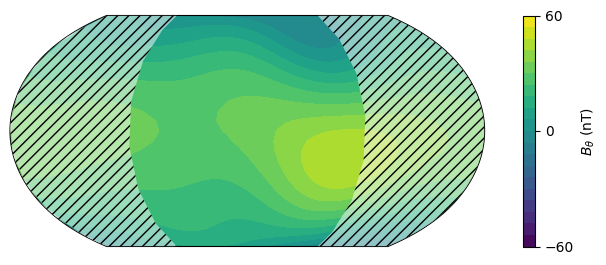

In [11]:
map_surface_rtp(data_out["MMA_SHA_2E"]["qs"][0, :])